In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pylab
import cvxpy as cp
from scipy.linalg import eigh
from collections import OrderedDict
import pandas as pd
import scipy as sp
import seaborn as sns
import scipy.stats as stats
import random
import argparse
from time import time
import os
#from google.colab import files
from scipy.sparse import coo_matrix
%load_ext autoreload
%autoreload 2

In [2]:
#from environment_adapted import Stochastic_env  # Import Stochastic environment
#from environment import Stochastic
#from bandit import HYBRID
#from main import *

In [3]:
nodes = int(input(" NODES in the graph : "  )) #number of arms
super_arm_sparsity = int(input(" number of chosen arms in the super arm is : "  )) #number of chosen arms
rounds = int(input(" rounds of observation (decision making) : "  )) # number of rounds of data we create

 NODES in the graph :  20
 number of chosen arms in the super arm is :  6
 rounds of observation (decision making) :  20000


In [4]:
# variable "n" is the number of nodes (arms)
def create_graph(n):
    
    p = float(input("* Please enter the probability of having an edge between any two nodes in your random graph:"  ))
    G = nx.gnp_random_graph(n=n,p=p,directed=True)
    DAG = nx.DiGraph([(u,v,{'weight':np.random.uniform(low=0.9,high=0.95)}) for (u,v) in G.edges() if u<v])
    print('* Is the graph a DAG? ',nx.is_directed_acyclic_graph(DAG))
    
    # building the adjacency numpy matrix of the graph
    edge_list = list(DAG.edges())
    number_of_edges = len(edge_list)
    w = np.zeros((n,n)) # the numpy adjacency matrix with all edge weights equal to 1
    
    ### the following for-loop can be removed and replaced with a one-line command
    for i in range(len(edge_list)):
        w[edge_list[i][0],edge_list[i][1]]=np.random.uniform(low=0.01,high=0.15)
    if np.count_nonzero(w)==number_of_edges:
        print('The adjacency matrix is correctly set as a randomly picked DAG!')
    temporary = (np.eye(w.shape[0])-w)
    C = np.linalg.inv(temporary)
    C_axis_0_sum = np.sum(C,axis=0)
    print('the elements of the vector C are:  ',np.transpose(C_axis_0_sum))
    return w , C
	
#       B

def instantaneous_Gaussian_rewards(maxx,minn):
    variance = float(input(" The variance for all reward distributions is : "  ))
    mean_b_gt_Gauss = np.random.uniform(low=minn, high=maxx, size=(nodes,1)) #choosing the ground truth (gt) means uniformally at random
    B = variance * np.random.randn(1,rounds) + mean_b_gt_Gauss[0] # create the samples
    for i in range(1,nodes):
        temporary = variance * np.random.randn(1,rounds) + mean_b_gt_Gauss[i]
        B = np.concatenate((B,temporary),axis=0)
    return B, mean_b_gt_Gauss;

def instantaneous_Bernoulli_rewards(maxx,minn):
    
    mean_b_gt_Bern = np.random.uniform(low=minn, high=maxx, size=(nodes,1)) #choosing the ground truth (gt) means uniformally at random
    B = np.asarray([np.random.binomial(size=rounds,n=1,p=mean_b_gt_Bern[0])]) # create the samples
    for i in range(1,nodes):
        temporary = np.asarray([np.random.binomial(size=rounds,n=1,p=mean_b_gt_Bern[i])])
        B = np.concatenate((B,temporary),axis=0)
    return B, mean_b_gt_Bern;
	
#   function to create the random action X

def rand_binary_array(number_of_chosen_arms=super_arm_sparsity,n=nodes): 
    
    temporary = np.zeros((n,1))
    temporary[:(number_of_chosen_arms)]  = 1
    np.random.shuffle(temporary)
    return temporary

def create_random_action(number_of_chosen_arms=super_arm_sparsity,n=rounds):

    X = rand_binary_array(number_of_chosen_arms=number_of_chosen_arms)
    for i in range(n-1):
        temporary = rand_binary_array(number_of_chosen_arms=number_of_chosen_arms)
        X = np.concatenate((X,temporary),axis=1)
    return X
	
def f_measure_func(x,xgt): # xgt is the ground truth variable 
    
    x=np.where(x!=0,1,0)
    xgt=np.where(xgt!=0,1,0)
    true_pos = np.count_nonzero(np.multiply(x,xgt))
    fals_pos = np.count_nonzero(np.where((x-xgt)>0,1,0))
    fals_neg = np.count_nonzero(np.where((xgt-x)>0,1,0))
    true_neg = nodes**2 - true_pos - fals_neg - fals_pos
    f_measure=true_pos/(true_pos+0.5*(fals_neg+fals_pos))
    
    return f_measure
	

In [5]:
#                        SEM + L1 graph learning
skiped = 0
best_gamma = 0.1
def graph_learning(A_gt ,observed_y ,observed_b ,nodes = nodes,skiped=skiped,best_gamma=best_gamma):
 
    if skiped==0: 
        gamma = np.array([0.00001,0.0001,0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10\
                          ,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9\
                          ,10,20,30,40,50,60,70,80,90,100,1000,10000,100000,1000000])
    elif skiped==1:
        gamma = np.asarray([best_gamma])
        
    error_SEM_L1 = np.ones([gamma.shape[0],1])*10000000000000000000
    for k in range (gamma.shape[0]):
        A        = cp.Variable((nodes,nodes))
        cost     = cp.sum_squares(observed_y-A*observed_y-observed_b)+gamma[k]*cp.atoms.norm1(A)
        obj      = cp.Minimize(cost)
        constr   = [cp.diag(A)==0,A[:,:]>=0]
        prob     = cp.Problem(obj,constr)
        opt_val  = prob.solve()
        solution_L1Norm = A.value

        error_SEM_L1[k] = np.sum(np.power((A_gt - A.value),2))/(nodes*nodes) 
    
        if error_SEM_L1[k]<=np.amin(error_SEM_L1):
            The_final_solution_SEM_L1=A.value
            solution_threshold_SEM_L1 = np.where(np.absolute(A.value)<\
                                             (0.1*np.amax(np.absolute(A.value))),0,A.value)
            solution_Boolean_SEM_L1 = np.where(solution_threshold_SEM_L1==0,0,1)
            best_gamma = gamma[k]
            optvalue1=opt_val

    f_measure = f_measure_func(solution_threshold_SEM_L1,A_gt)
    print('the f-measure is : ', f_measure)
    
        
    return The_final_solution_SEM_L1, f_measure, best_gamma
	

In [6]:
#    Finding the best action according to the given knowledge of A (ground truth adjacency) and b (expected values of base arms)
# super_arm_sparsity variable is the maximum number of arms that we can choose. 

def Best_action_func(A, b,s = super_arm_sparsity):

    temp_inv     = np.linalg.inv(np.eye(nodes)-A)
    b_diag       = np.diagflat(b)
    C            = np.matmul(temp_inv,b_diag)
    C_axis_0_sum = np.sum(C,axis=0)
    ind          = np.argsort(C_axis_0_sum,axis=0)[-s:]
    x            = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i],0]=1
    
    return x


In [7]:
#              UCB  function as part of decision making strategy

def UCB_func(t, x, T, b_bar, b_hat, b):
    
    temporary_1 = np.zeros((nodes,1))
    for i in range(nodes):
        temporary_1[i,0] = b[i,t]
    
    temporary_2 = np.where(x!=0)
    for i in range(temporary_2[0].shape[0]):
        j = temporary_2[0][i]
        #temp8 = T[j,0]
        b_bar[j,0] = (b_bar[j,0]*T[j,0]+temporary_1[j,0])/int(round(T[j,0]+1))
        T[j,0] = int(round(T[j,0]+1))
        temporary_3 = b_bar[j,0]+np.sqrt((3*np.log(t+1))/(2*T[j,0])) # UCB calculations 
        b_hat[j,0] = temporary_3
        ###############################################################
    temporary_4 = np.where(x==0)
    for i in range(temporary_4[0].shape[0]):
        jjj = temporary_4[0][i]
        temporary_3_j = b_bar[jjj,0]+np.sqrt((3*np.log(t+1))/(2*T[jjj,0])) # UCB calculations
        b_hat[jjj,0] = temporary_3_j
        
    return T, b_bar, b_hat

def overall_reward(act,exp_b,A_gt):
    
    temp_inv = np.linalg.inv(np.eye(nodes)-A_gt)
    temp_multiply = np.multiply(exp_b,act)
    temporary = np.matmul(temp_inv,temp_multiply)
    reward = np.sum(temporary)
    
    return reward


# create the graph and the B
f_measure = 0
collected_expected_rewards = np.zeros((1,rounds))
collected_instantaneous_rewards = np.zeros((1,rounds))
instantaneous_regret = np.zeros((1,rounds))
expected_regret = np.zeros((1,rounds))

w_gt, C_gt = create_graph(n=nodes); # create the gt graph. w_gt is the gt adjacency and C_gt is the (I-w_gt)^{-1} 

B, mean_b_gt = instantaneous_Gaussian_rewards(maxx=0.7,minn=0.3); # create the gt 'b'
### B is the matrix of all instantaneous rewards for all the base arms

print('The elements of the vector of expected instantaneous rewards of base arms are:  ', mean_b_gt)

T = np.ones((nodes,1))
b_bar = np.ones((nodes,1))
b_hat = np.ones((nodes,1))

for i in range(B.shape[0]):
    b_hat[i,0] = B[i,0]

# calculate the best action for the given graph and 'b'

best_action_choice = Best_action_func(A=w_gt, b=mean_b_gt, s=super_arm_sparsity)

# calculate the best reward for the best action so that later use it in regret calculation
best_expected_reward = overall_reward(act=best_action_choice, exp_b=mean_b_gt, A_gt=w_gt)
print('the best reward is ', best_expected_reward)
print('density of the ground truth graph is: ',(np.count_nonzero(w_gt))/((nodes*nodes)-nodes))

* Please enter the probability of having an edge between any two nodes in your random graph: 0.15


* Is the graph a DAG?  True
The adjacency matrix is correctly set as a randomly picked DAG!
the elements of the vector C are:   [1.         1.         1.         1.02397873 1.         1.2399273
 1.         1.         1.0312203  1.         1.2755855  1.24057911
 1.13643707 1.09245866 1.09590617 1.36016499 1.31931443 1.50394887
 1.21831202 1.47248   ]


 The variance for all reward distributions is :  0.0025


The elements of the vector of expected instantaneous rewards of base arms are:   [[0.62510478]
 [0.48423533]
 [0.40904447]
 [0.33565592]
 [0.3980718 ]
 [0.36827773]
 [0.30336387]
 [0.57708668]
 [0.51156012]
 [0.32984658]
 [0.33199692]
 [0.52301038]
 [0.63077602]
 [0.61394426]
 [0.34646046]
 [0.4486488 ]
 [0.65113115]
 [0.58942076]
 [0.51130798]
 [0.31596152]]
the best reward is  4.4069919120125505
density of the ground truth graph is:  0.08421052631578947


In [8]:
Y_checking = C_gt @ B

In [9]:
print('the minimum value of the Y vector is ... ', np.amin(Y_checking))
print('the maximum value of the Y vector is ... ', np.amax(Y_checking))
Y_big_and_small = [np.amin(Y_checking), np.amax(Y_checking)]
print('This was to check if turning the rewards into losses between [-1,0] can happen for the created data and the answer is ... ')
if all(i < 1 for i in Y_big_and_small):
    print('YES')

the minimum value of the Y vector is ...  0.3067530105436491
the maximum value of the Y vector is ...  0.7244437065849212
This was to check if turning the rewards into losses between [-1,0] can happen for the created data and the answer is ... 
YES


In [10]:
np.amax(B)

0.6605586061045348

In [11]:
np.amin(B)

0.29281440832704303

In [12]:
print('the best reward is ', best_expected_reward)

the best reward is  4.4069919120125505


In [13]:
# s is the sparsity of the chosen action vector 
# nodes is the number of arms 

### the following function creates the initialization matrix

def initial_rounds_actions(nodes,s):

    initial_actions=np.zeros((nodes,nodes))
    initial_actions=initial_actions+np.eye(nodes)
    for i in range(nodes):
        if i<=s:
            for j in range(i):
                initial_actions[i,j]=1
        elif i>s:
            temp=rand_binary_array(number_of_chosen_arms=s-1,n=i-1)
            temp1=np.nonzero(temp)
            for j in range(temp1[0].shape[0]):
                temp2=temp1[0][j]
                initial_actions[i,temp2]=1
            
    np.random.shuffle(initial_actions)
    needed_initial_matrix=initial_actions.T
    
    return needed_initial_matrix

In [14]:
def initial_rounds_actions(nodes,s):

    initial_actions=np.zeros((nodes,nodes))
    initial_actions=initial_actions+np.eye(nodes)
    for i in range(nodes):
        if i<s:
            for j in range(i):
                initial_actions[i,j]=1
        elif i>=s:
            temp=rand_binary_array(number_of_chosen_arms=s-1,n=i-1)
            temp1=np.nonzero(temp)
            for j in range(temp1[0].shape[0]):
                temp2=temp1[0][j]
                initial_actions[i,temp2]=1
            
    #np.random.shuffle(initial_actions)
    needed_initial_matrix=initial_actions.T
    
    return needed_initial_matrix

In [15]:
   
 #         Enter the number of initial rounds 
#initial_rounds = int(input(" number of initial rounds is : "  )) 


################## initial rounds ######################

#all_actions_taken = np.zeros((nodes,initial_rounds))
#for i in range(initial_rounds):
#    temp61 = np.asarray([all_actions_taken[:,i]])+create_random_action(number_of_chosen_arms=super_arm_sparsity,n=1)
#    all_actions_taken[:,i] = temp61[:,0]
#np.where(all_actions_taken==0,0,1)
#for i in range(nodes):
#    all_actions_taken[i,i]=1


In [16]:
all_actions_taken=initial_rounds_actions(nodes=nodes,s=super_arm_sparsity)
initial_rounds=nodes

In [17]:

#########################################################

temp1 = np.transpose(np.asarray([B[:,0]]))
Y = np.matmul(C_gt,np.multiply(temp1,np.transpose(np.asarray([all_actions_taken[:,0]]))))
temp_act = np.transpose(np.asarray([all_actions_taken[:,0]]))
collected_expected_rewards[0,0] = overall_reward(act=temp_act, exp_b=mean_b_gt, A_gt=w_gt)
collected_instantaneous_rewards[0,0] = overall_reward(act=temp_act, exp_b=temp1, A_gt=w_gt)
print('collected reward of round ', 0 , ' is ', collected_expected_rewards[0,0])
expected_regret[0,0] = best_expected_reward - collected_expected_rewards[0,0]
instantaneous_regret[0,0] = overall_reward(act=best_action_choice, exp_b=temp1, A_gt=w_gt)-collected_instantaneous_rewards[0,0]
T, b_bar, b_hat = UCB_func(t=0, x=all_actions_taken[:,0], T=T, b_bar=b_bar, b_hat=b_hat, b=B) 

################ initial rounds ######################

for i in range(1,initial_rounds):
    
    temp = np.multiply(np.transpose(np.asarray([B[:,i]])),np.transpose(np.asarray([all_actions_taken[:,i]])))
    temp_y = np.matmul(C_gt,temp)
    Y = np.concatenate((Y,temp_y),axis=1)
    temp_act = np.transpose(np.asarray([all_actions_taken[:,i]]))
    temp_exp_b = np.transpose(np.asarray([B[:,i]]))
    collected_expected_rewards[0,i] = overall_reward(act=temp_act,exp_b=mean_b_gt,A_gt=w_gt)
    collected_instantaneous_rewards[0,i] = overall_reward(act=temp_act,exp_b=temp_exp_b,A_gt=w_gt)
    expected_regret[0,i] = best_expected_reward - collected_expected_rewards[0,i]
    instantaneous_regret[0,i] = overall_reward(act=best_action_choice, exp_b=temp_exp_b, A_gt=w_gt)-collected_instantaneous_rewards[0,i]
    T, b_bar, b_hat = UCB_func(t=i, x=all_actions_taken[:,i], T=T, b_bar=b_bar, b_hat=b_hat, b=B)
    print('collected reward of round ', i , ' is ', collected_expected_rewards[0,i])
	
	

collected reward of round  0  is  0.6251047815604382
collected reward of round  1  is  1.1093401071139275
collected reward of round  2  is  1.518384572739665
collected reward of round  3  is  1.8620890945227089
collected reward of round  4  is  2.260160891719092
collected reward of round  5  is  2.7167985052273442
collected reward of round  6  is  2.563524758418456
collected reward of round  7  is  2.9501806640597925
collected reward of round  8  is  2.805917233409488
collected reward of round  9  is  2.2406688442230944
collected reward of round  10  is  2.5133276026685247
collected reward of round  11  is  2.809566464926974
collected reward of round  12  is  2.925586072868681
collected reward of round  13  is  3.08398983092056
collected reward of round  14  is  2.6156097292425144
collected reward of round  15  is  2.9915676657383345
collected reward of round  16  is  3.1307683211634156
collected reward of round  17  is  3.193422753597128
collected reward of round  18  is  3.2268699776

## 1. acting based on the SEM-UCB algorithm

In [18]:
################### acting based on the decisions taken by the agent 


for i in range(initial_rounds,rounds):
    print('we are in round  ', i)
    observed_b = np.multiply(all_actions_taken,B[:,0:all_actions_taken.shape[1]])
    print('shape of observed instantaneous rewards matrix is ',observed_b.shape)
    if f_measure==1.0:
        
        temp41 = np.transpose(np.asarray([B[:,i]]))
    
        agent_moment_action = Best_action_func(A=w_hat, b=b_hat, s=super_arm_sparsity)
        all_actions_taken = np.concatenate((all_actions_taken,agent_moment_action), axis=1)
        Y = np.concatenate((Y,np.matmul(C_gt,np.multiply(temp41,agent_moment_action))), axis=1)
    
        collected_expected_rewards[0,i]=overall_reward(act=agent_moment_action,exp_b=mean_b_gt,A_gt=w_gt)
        collected_instantaneous_rewards[0,i]=overall_reward(act=agent_moment_action,exp_b=temp41,A_gt=w_gt)
        expected_regret[0,i]=best_expected_reward-collected_expected_rewards[0,i]
        instantaneous_regret[0,i]=overall_reward(act=best_action_choice,exp_b=temp41,A_gt=w_gt)-collected_instantaneous_rewards[0,i]
    
        print('collected reward of this round is: ', collected_expected_rewards[0,i])
    
        T, b_bar, b_hat = UCB_func(t=i, x=agent_moment_action, T=T, b_bar=b_bar, b_hat=b_hat, b=B)
        
    else:     
        
        w_hat, f_measure, best_gamma = graph_learning(A_gt=w_gt,observed_y= Y,observed_b=observed_b,nodes=nodes,skiped=skiped,best_gamma=best_gamma)
        if f_measure>=0.99:
            skiped = 1
        else:
            skiped = 0
    
        temp41 = np.transpose(np.asarray([B[:,i]]))
    
        agent_moment_action = Best_action_func(A=w_hat, b=b_hat, s=super_arm_sparsity)
        all_actions_taken = np.concatenate((all_actions_taken,agent_moment_action), axis=1)
        Y = np.concatenate((Y,np.matmul(C_gt,np.multiply(temp41,agent_moment_action))), axis=1)
    
        collected_expected_rewards[0,i]=overall_reward(act=agent_moment_action,exp_b=mean_b_gt,A_gt=w_gt)
        collected_instantaneous_rewards[0,i]=overall_reward(act=agent_moment_action,exp_b=temp41,A_gt=w_gt)
        expected_regret[0,i]=best_expected_reward-collected_expected_rewards[0,i]
        instantaneous_regret[0,i]=overall_reward(act=best_action_choice,exp_b=temp41,A_gt=w_gt)-collected_instantaneous_rewards[0,i]
    
        print('collected reward of this round is: ', collected_expected_rewards[0,i])
    
        T, b_bar, b_hat = UCB_func(t=i, x=agent_moment_action, T=T, b_bar=b_bar, b_hat=b_hat, b=B)
	


we are in round   20
shape of observed instantaneous rewards matrix is  (20, 20)


C:\Users\Behzad_NouraniKoliji\anaconda3\Lib\site-packages\cvxpy\expressions\expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Behzad_NouraniKoliji\anaconda3\Lib\site-packages\cvxpy\expressions\expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, Use

the f-measure is :  1.0
collected reward of this round is:  4.114630195602027
we are in round   21
shape of observed instantaneous rewards matrix is  (20, 21)
collected reward of this round is:  4.0927572232880145
we are in round   22
shape of observed instantaneous rewards matrix is  (20, 22)
collected reward of this round is:  4.153229559037352
we are in round   23
shape of observed instantaneous rewards matrix is  (20, 23)
collected reward of this round is:  3.893315015214288
we are in round   24
shape of observed instantaneous rewards matrix is  (20, 24)
collected reward of this round is:  4.114630195602027
we are in round   25
shape of observed instantaneous rewards matrix is  (20, 25)
collected reward of this round is:  4.144905249139408
we are in round   26
shape of observed instantaneous rewards matrix is  (20, 26)
collected reward of this round is:  4.221231066034114
we are in round   27
shape of observed instantaneous rewards matrix is  (20, 27)
collected reward of this round

## viusalizing all the actions taken during all rounds for the SEM-UCB algorithm

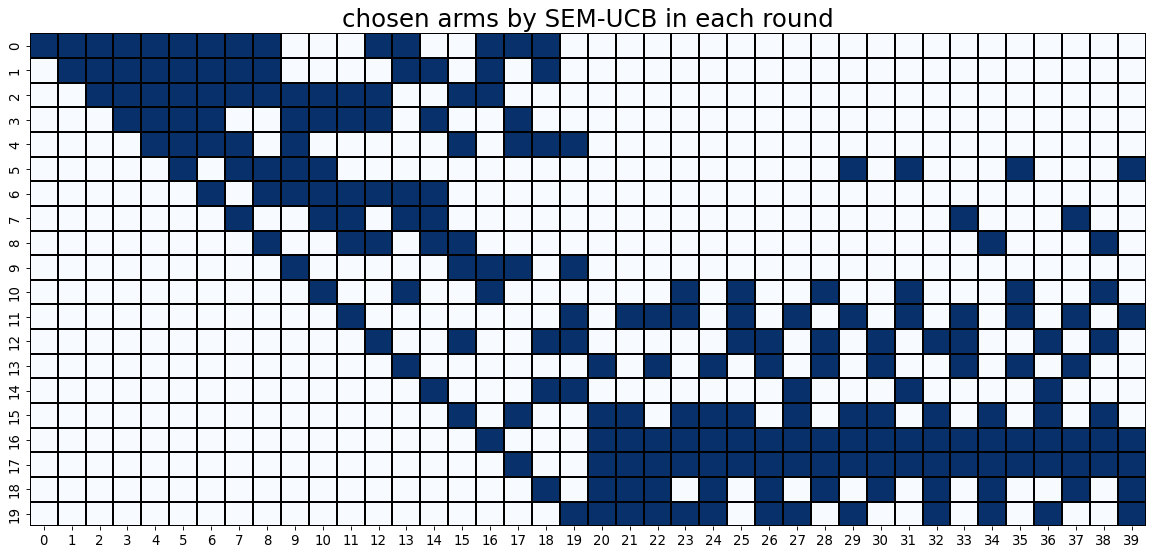

In [19]:
# Import Dataset

df = all_actions_taken[:,:40]

# Plot
fig3 = plt.figure(figsize=(18,8), dpi= 80)
tttt=sns.heatmap(df, cmap='Blues',linewidth=0.01,linecolor='k',cbar=False)
#tttt.set_xticklabels(tttt.get_xticklabels(), rotation=-60)
# Decorations
plt.title('chosen arms by SEM-UCB in each round', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
fig3.savefig("Chosen arms by SEM-UCB in each round.jpg", format = 'jpg', dpi = 200)

## 2. Acting uniformely at random

In [20]:
#          Uniformly at random taken actions 

randomly_taken_actions = create_random_action(n=rounds)
collected_expected_random_rewards = np.zeros((1,rounds))
collected_instantaneous_random_rewards = np.zeros((1,rounds))
expected_random_regret = np.zeros((1,rounds))
instantaneous_random_regret = np.zeros((1,rounds))

for i in range(rounds):
    
    temp42 = np.transpose(np.asarray([B[:,i]]))
    temp35 = np.transpose(np.asarray([randomly_taken_actions[:,i]]))
    collected_instantaneous_random_rewards[0,i] = overall_reward(act=temp35, exp_b=temp42, A_gt=w_gt)
    collected_expected_random_rewards[0,i] = overall_reward(act=temp35, exp_b=mean_b_gt, A_gt=w_gt)
    expected_random_regret[0,i] = best_expected_reward - collected_expected_random_rewards[0,i] 
    instantaneous_random_regret[0,i]=overall_reward\
    (act=best_action_choice,exp_b=temp42,A_gt=w_gt)-collected_instantaneous_random_rewards[0,i]

## 3. Acting based on Chen's algorithm (CUCB)

In [21]:
# def UCB_func(t, act, T, b_bar, b_hat, b):
    
#     temporary_1 = np.zeros((nodes,1))
#     for i in range(nodes):
#         temporary_1[i,0] = b[i,t]
    
#     temporary_2 = np.where(act!=0)
#     for i in range(temporary_2[0].shape[0]):
#         j = temporary_2[0][i]
#         #temp8 = T[j,0]
#         b_bar[j,0] = (b_bar[j,0]*T[j,0]+temporary_1[j,0])/int(round(T[j,0]+1))
#         T[j,0] = int(round(T[j,0]+1))
#         temporary_3 = b_bar[j,0]+np.sqrt((3*np.log(t+1))/(2*T[j,0])) # UCB calculations 
#         b_hat[j,0] = temporary_3
#         ###############################################################
#     temporary_4 = np.where(act==0)
#     for i in range(temporary_4[0].shape[0]):
#         jjj = temporary_4[0][i]
#         temporary_3_j = b_bar[jjj,0]+np.sqrt((3*np.log(t+1))/(2*T[jjj,0])) # UCB calculations
#         b_hat[jjj,0] = temporary_3_j
        
#     return T, b_bar, b_hat

In [22]:
# acting naively based on Chen algorithm for the y feedbacks
##################   UCB  function as part of decision making strategy

def UCB_func_chen(t, act, T, b_bar, b_hat, b):
    
    temp1 = np.zeros((nodes,1))
    for i in range(nodes):
        temp1[i,0] = b[i,t]
    
    temp2 = np.where(act!=0)
    for i in range(temp2[0].shape[0]):
        j = temp2[0][i]
        #temp8 = T[j,0]
        b_bar[j,0] = (b_bar[j,0]*T[j,0]+temp1[j,0])/int(round(T[j,0]+1))
        T[j,0] = int(round(T[j,0]+1))
        
        temp3 = b_bar[j,0]+np.sqrt((3*np.log(t+1))/(2*T[j,0]))
        b_hat[j,0] = temp3
        ######################################################
    temp4 = np.where(act==0)
    for i in range(temp4[0].shape[0]):
        jj = temp4[0][i]
        temp3_j = b_bar[jj,0]+np.sqrt((3*np.log(t+1))/(2*T[jj,0]))
        b_hat[jj,0] = temp3_j
            
    return T, b_bar, b_hat

#######################################################

In [23]:
collected_rewards_chen = np.zeros((1,rounds)) 
expected_regret_chen = np.zeros((1,rounds))

T_chen = np.ones((nodes,1))
b_bar = np.ones((nodes,1))
b_hat = np.ones((nodes,1))

################## initial rounds chen ######################

all_actions_taken_chen = create_random_action(n=initial_rounds)
temp_b = np.transpose(np.asarray([B[:,0]]))
Y_chen = np.matmul(C_gt,np.multiply(temp_b,np.transpose(np.asarray([all_actions_taken_chen[:,0]]))))

# for i in range(Y_chen.shape[0]):
#     y_hat[i,0] = Y_chen[i,0]


temp33_chen = np.transpose(np.asarray([all_actions_taken_chen[:,0]]))
collected_rewards_chen[0,0] = np.amax(np.cumsum(Y_chen[:,0],axis=0))
print('collected reward of round ', 0 , ' is ', collected_rewards_chen[0,0])
expected_regret_chen[0,0] = best_expected_reward - collected_rewards_chen[0,0]
T_chen, b_bar, b_hat = UCB_func_chen(t=0, act=all_actions_taken_chen[:,0], T=T_chen, b_bar=b_bar, b_hat=b_hat, b=B) 

################ initial rounds chen ######################

for i in range(1,initial_rounds):
    
    Y_chen = np.concatenate\
    ((Y_chen,np.matmul(C_gt,np.multiply(np.transpose(np.asarray([B[:,i]])),np.transpose(np.asarray([all_actions_taken_chen[:,i]]))))),axis=1)

    temp_act = np.transpose(np.asarray([all_actions_taken_chen[:,i]]))
    temp_y = np.matmul(C_gt,np.multiply(mean_b_gt,temp_act))
    
    temp9_chen = np.transpose(np.asarray([all_actions_taken[:,i]]))
    #collected_rewards_chen[0,i] = np.amax(np.cumsum(Y_chen[:,i],axis=0))
    collected_rewards_chen[0,i] = np.amax(np.cumsum(temp_y,axis=0))
    print('collected reward of round ', i , ' is ', collected_rewards_chen[0,i])
    expected_regret_chen[0,i] = best_expected_reward - collected_rewards_chen[0,i] 
    T_chen, b_bar, b_hat = UCB_func_chen(t=i, act=all_actions_taken_chen[:,i], T=T_chen, b_bar=b_bar, b_hat=b_hat, b=B)
    

################### acting based on Chen's algorithm ##################

# def best_action_Chen(y=y_hat, s = super_arm_sparsity): 
    
#     ind = np.argsort(y,axis=0)[-s:]
#     x = np.zeros((nodes,1))
#     for i in range(ind.shape[0]):
#         x[ind[i],0]=1
    
#     return x

########################################################################

for i in range(initial_rounds,rounds):

    agent_moment_action_chen = Best_action_func(A=w_gt, b=b_hat , s=super_arm_sparsity)
    all_actions_taken_chen = np.concatenate((all_actions_taken_chen,agent_moment_action_chen), axis=1)
    
    temp_B = np.transpose(np.asarray([B[:,i]]))
    y_chen_this_round = np.matmul(C_gt,np.multiply(temp_B,agent_moment_action_chen))
    Y_chen = np.concatenate((Y_chen,y_chen_this_round), axis=1)

    
    #temp96_chen = agent_moment_action_chen
    temp_y = np.matmul(C_gt,np.multiply(mean_b_gt,agent_moment_action_chen))
    collected_rewards_chen[0,i] = np.amax(np.cumsum(temp_y,axis=0))
    #collected_rewards_chen[0,i] = np.amax(np.cumsum(y_chen_this_round,axis=0))
    expected_regret_chen[0,i] = best_expected_reward - collected_rewards_chen[0,i] 
    print('collected reward of round',i ,' is: ', collected_rewards_chen[0,i])
    
    T_chen, b_bar, b_hat = UCB_func_chen(t=i, act=agent_moment_action_chen, T=T_chen, b_bar=b_bar, b_hat=b_hat, b=B)
    

collected reward of round  0  is  3.1968253868860343
collected reward of round  1  is  2.528024293260268
collected reward of round  2  is  2.6478296457227093
collected reward of round  3  is  3.277879817087298
collected reward of round  4  is  3.288888404232295
collected reward of round  5  is  3.3989666813542447
collected reward of round  6  is  3.2219943509418703
collected reward of round  7  is  4.075476377897952
collected reward of round  8  is  3.1812086132565502
collected reward of round  9  is  4.099199120900398
collected reward of round  10  is  3.3777009224272616
collected reward of round  11  is  3.2464327612178843
collected reward of round  12  is  3.7881194603115382
collected reward of round  13  is  3.1688738901603983
collected reward of round  14  is  3.6372159738866197
collected reward of round  15  is  3.4974632209590863
collected reward of round  16  is  2.9404444441332673
collected reward of round  17  is  2.7571091591189174
collected reward of round  18  is  2.950708

## 4. Tang's Combinatorial algorithm (DFL-CSR)

In [24]:
# acting naively based on Chen algorithm for the y feedbacks
##   UCB  function as part of decision making strategy

def UCB_func_tang(t, x, T, y_bar_tang, y_hat_tang, y):
    
    temp6 = np.zeros((nodes,1))
    for i in range(nodes):
        temp6[i,0] = y[i,t]
    temp7 = np.where(x!=0)
    for i in range(temp7[0].shape[0]):
        j = temp7[0][i]
        #temp8 = T[j,0]
        y_bar_tang[j,0] = (y_bar_tang[j,0]*T[j,0]+temp6[j,0])/int(round(T[j,0]+1))
        T[j,0] = int(round(T[j,0]+1))
        if t==0:
            t+=1
        temp101_tang = np.log(((t)**(2/3))/(nodes*T[j,0])) #starting the UCB calculation
        temp102_tang = max([temp101_tang,0])
        temp103_tang = temp102_tang/T[j,0]
        temp10 = y_bar_tang[j,0]+np.sqrt(temp103_tang) # this is the UCB 
        y_hat_tang[j,0] = temp10
    #########################################################
    temp8 = np.where(x==0)
    for i in range(temp8[0].shape[0]):
        jj = temp8[0][i]
        #temp8 = T[j,0]
        #y_bar_tang[j,0] = (y_bar_tang[j,0]*T[j,0]+temp6[j,0])/int(round(T[j,0]+1))
        #T[j,0] = int(round(T[j,0]+1))
        if t==0:
            t+=1
        temp101_tang_j = np.log(((t)**(2/3))/(nodes*T[jj,0])) #starting the UCB calculation
        temp102_tang_j = max([temp101_tang_j,0])
        temp103_tang_j = temp102_tang_j/T[jj,0]
        temp10_j = y_bar_tang[jj,0]+np.sqrt(temp103_tang) # this is the UCB 
        y_hat_tang[jj,0] = temp10_j
    
    return T, y_bar_tang, y_hat_tang

#######################################################

collected_rewards_tang = np.zeros((1,rounds)) 
expected_regret_tang = np.zeros((1,rounds))

T_tang = np.ones((nodes,1))
y_bar_tang = np.ones((nodes,1))
y_hat_tang = np.ones((nodes,1))

################## initial rounds Tang ######################

all_actions_taken_tang = create_random_action(n=initial_rounds)
temp30_tang = np.transpose(np.asarray([B[:,0]]))
Y_tang = np.matmul(C_gt,np.multiply(temp30_tang,np.transpose(np.asarray([all_actions_taken_tang[:,0]]))))

for i in range(Y_tang.shape[0]):
    y_hat_tang[i,0] = Y_tang[i,0]


temp33_tang = np.transpose(np.asarray([all_actions_taken_tang[:,0]]))
collected_rewards_tang[0,0] = np.amax(np.cumsum(Y_tang[:,0],axis=0))
print('collected reward of round ', 0 , ' is ', collected_rewards_tang[0,0])
expected_regret_tang[0,0] = best_expected_reward - collected_rewards_tang[0,0]
T_tang, y_bar_tang, y_hat_tang = UCB_func_tang\
(t=0, x=all_actions_taken_tang[:,0], T=T_tang, y_bar_tang=y_bar_tang, y_hat_tang=y_hat_tang, y=Y_tang) 

################ initial rounds Tang ######################

for i in range(1,initial_rounds):
    
    Y_tang = np.concatenate\
    ((Y_tang,np.matmul(C_gt,np.multiply(np.transpose(np.asarray([B[:,i]])),np.transpose(np.asarray([all_actions_taken_tang[:,i]]))))),axis=1)

    temp98_tang = np.transpose(np.asarray([all_actions_taken_tang[:,i]]))
    temp99_tang = np.matmul(C_gt,np.multiply(mean_b_gt,temp98_tang))
    
    temp9_tang = np.transpose(np.asarray([all_actions_taken[:,i]]))
    #collected_rewards_tang[0,i] = np.amax(np.cumsum(Y_tang[:,i],axis=0))
    collected_rewards_tang[0,i] = np.amax(np.cumsum(temp99_tang,axis=0))
    print('collected reward of round ', i , ' is ', collected_rewards_tang[0,i])
    expected_regret_tang[0,i] = best_expected_reward - collected_rewards_tang[0,i] 
    T_tang, y_bar_tang, y_hat_tang = UCB_func_tang\
    (t=i, x=all_actions_taken_tang[:,i], T=T_tang, y_bar_tang=y_bar_tang, y_hat_tang=y_hat_tang, y=Y_tang)
    

################### acting based on Tang's algorithm ##################

def best_action_tang(y=y_hat_tang, s = super_arm_sparsity): 
    
    ind = np.argsort(y,axis=0)[-s:]
    x = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i],0]=1
    
    return x

########################################################################

for i in range(initial_rounds,rounds):

    agent_moment_action_tang = best_action_tang(y=y_hat_tang, s = super_arm_sparsity)
    all_actions_taken_tang = np.concatenate((all_actions_taken_tang,agent_moment_action_tang), axis=1)
    #print('the actions are not changing!  ',(all_actions_taken_tang[0,i]==all_actions_taken_tang[0,i-1]).all())
    #print('y_hat_tang is:  ',y_hat_tang)
    
    temp97_tang = np.transpose(np.asarray([B[:,i]]))
    y_tang_this_round = np.matmul(C_gt,np.multiply(temp97_tang,agent_moment_action_tang))
    Y_tang = np.concatenate((Y_tang,y_tang_this_round), axis=1)

    
    temp96_tang = agent_moment_action_tang
    temp95_tang = np.matmul(C_gt,np.multiply(mean_b_gt,temp96_tang))
    collected_rewards_tang[0,i] = np.amax(np.cumsum(temp95_tang,axis=0))
    #collected_rewards_tang[0,i] = np.amax(np.cumsum(y_tang_this_round,axis=0))
    expected_regret_tang[0,i] = best_expected_reward - collected_rewards_tang[0,i] 
    print('collected reward of round',i ,' is: ', collected_rewards_tang[0,i])
    
    T_tang, y_bar_tang, y_hat_tang = UCB_func_tang\
    (t=i, x=agent_moment_action_tang, T=T_tang, y_bar_tang=y_bar_tang, y_hat_tang=y_hat_tang, y=Y_tang)
    

collected reward of round  0  is  3.433074828693787
collected reward of round  1  is  2.537733130819956
collected reward of round  2  is  3.0723241552788654
collected reward of round  3  is  2.588014563815972
collected reward of round  4  is  3.352462617088758
collected reward of round  5  is  2.4879089454282735
collected reward of round  6  is  3.2171947922211177
collected reward of round  7  is  3.2494225646596355
collected reward of round  8  is  3.493184893525659
collected reward of round  9  is  2.8781560183618993
collected reward of round  10  is  2.6518442040868186
collected reward of round  11  is  2.790735383775498
collected reward of round  12  is  2.913144927536958
collected reward of round  13  is  3.5829808503838123
collected reward of round  14  is  3.035840293636595
collected reward of round  15  is  3.3852484406748085
collected reward of round  16  is  2.878598265978377
collected reward of round  17  is  3.751825542875162
collected reward of round  18  is  3.03142976517

## 5. Implementation of CTS with normalized y_{i}

In [25]:
###################### the following must be executed at the beginning of each decision making point 
#posterior_cts = np.zeros((nodes,1))
#for i in range(nodes):
#    posterior_cts[i,0] = np.random.beta(a_it[i,0], b_it[i,0], size=1)
    
############################################ 
def CTS_update(a_it, b_it, action_vector, x_mean_cts, t, T_cts):

    action_vector = np.asarray([action_vector]).T 
    for i in range(nodes):
        
        if action_vector[i,0]!=0:
            x_mean_cts[i,0]=(x_mean_cts[i,0]*T_cts[i,0]+B[i,t])/(T_cts[i,0]+1)
            T_cts[i,0]+=1
            temp = np.random.binomial(size=1,n=1,p=x_mean_cts[i,0])
            a_it[i,0] = a_it[i,0] + temp
            b_it[i,0] = b_it[i,0] + 1-temp

    return a_it, b_it, x_mean_cts, T_cts
    

In [26]:
# def biggest_y_i(s=super_arm_sparsity):
#     b_max_i = np.transpose(np.asarray([np.amax(B,axis=1)]))
#     b_diag = np.diagflat(b_max_i) 
#     C = np.matmul(C_gt,b_diag)
#     C_sorted = np.sort(C)
#     temp_C_biggest = C_sorted[:,-s:]
#     temp_biggest_sum = np.cumsum(temp_C_biggest,axis=1)
#     y_max_i = (np.transpose(np.asarray([temp_biggest_sum[:,-1]])))
    
#     return y_max_i


# def best_action_pcts(y, s = super_arm_sparsity): 
    
#     ind = np.argsort(y,axis=0)[-s:]
#     x = np.zeros((nodes,1))
#     for i in range(ind.shape[0]):
#         x[ind[i],0]=1
    
#     return x

# def PCTS_update(a_it, b_it, action_vector, x_mean_pcts, t, T_pcts):

#     action_vector = np.asarray([action_vector]).T 
#     for i in range(nodes):
        
#         if action_vector[i,0]!=0:
#             x_mean_pcts[i,0]=(x_mean_pcts[i,0]*T_pcts[i,0]+Y_pcts_normal[i,t])/(T_pcts[i,0]+1)
#             T_pcts[i,0]+=1
#             temp80 = np.random.binomial(size=1,n=1,p=x_mean_pcts[i,0])
#             a_it[i,0] = a_it[i,0] + temp80
#             b_it[i,0] = b_it[i,0] + 1-temp80

#     return a_it, b_it, x_mean_pcts, T_pcts

#### acting based on Huyuk's algorithm (CTS) for the y feedbacks

In [27]:

###############y_i_max = biggest_y_i();
collected_rewards_cts = np.zeros((1,rounds)) 
expected_regret_cts = np.zeros((1,rounds))
collected_expected_rewards_cts = np.zeros((1,rounds))
collected_instantaneous_rewards_cts = np.zeros((1,rounds))
instantaneous_regret_cts = np.zeros((1,rounds))
#y_bar_pcts = np.ones((nodes,1))
#y_hat_pcts = np.ones((nodes,1))

a_it = np.ones((nodes,1))
b_it = np.ones((nodes,1))
T_cts = np.ones((nodes,1))

################## initial rounds PCTS ######################

all_actions_taken_cts = create_random_action(n=initial_rounds)

agent_moment_action_cts= all_actions_taken_cts[:, 0].reshape(-1, 1)
#first_b_cts = np.transpose(np.asarray([B[:,0]]))
#Y_cts = np.matmul(C_gt,np.multiply(first_b_cts,np.transpose(np.asarray([all_actions_taken_cts[:,0]]))))

x_mean_cts = np.ones((nodes,1))*0.5 #np.asarray([B[:,0]]).T

#for i in range(Y_pcts.shape[0]):
#    y_hat_pcts[i,0] = Y_pcts[i,0]

###############temp33_pcts = np.transpose(np.asarray([all_actions_taken_pcts[:,0]]))
#temp_y = np.matmul(C_gt,np.multiply(mean_b_gt,np.transpose(np.asarray([all_actions_taken_cts[:,0]]))))
collected_rewards_cts[0,0] = overall_reward(act=agent_moment_action_cts,exp_b=mean_b_gt,A_gt=w_gt)
print('collected reward of round ', 0 , ' is ', collected_rewards_cts[0,0])
expected_regret_cts[0,0] = best_expected_reward - collected_rewards_cts[0,0]
a_it, b_it, x_mean_cts, T_cts = CTS_update(a_it=a_it,b_it=b_it,action_vector=all_actions_taken_cts[:,0],x_mean_cts=x_mean_cts,t=0,T_cts=T_cts) 

collected reward of round  0  is  3.2353788830060095


C:\Users\Behzad_NouraniKoliji\AppData\Local\Temp\ipykernel_8536\2741015446.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a_it[i,0] = a_it[i,0] + temp
C:\Users\Behzad_NouraniKoliji\AppData\Local\Temp\ipykernel_8536\2741015446.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_it[i,0] = b_it[i,0] + 1-temp


In [28]:
########## CTS  function as part of decision making strategy ##########################


################ initial rounds cts ######################

for i in range(1,initial_rounds):
    
    #temp_y = np.matmul(C_gt,np.multiply(np.transpose(np.asarray([B[:,i]])),np.transpose(np.asarray([all_actions_taken_pcts[:,i]]))))
    #Y_cts = np.concatenate((Y_cts,temp_y),axis=1)

    temp_act = np.transpose(np.asarray([all_actions_taken_cts[:,i]]))
    temp_y = np.matmul(C_gt,np.multiply(mean_b_gt,temp_act))
    
    #temp9_pcts = np.transpose(np.asarray([all_actions_taken[:,i]]))
    #collected_rewards_chen[0,i] = np.amax(np.cumsum(Y_chen[:,i],axis=0))
    collected_rewards_cts[0,i] = np.amax(np.cumsum(temp_y,axis=0))
    print('collected reward of round ', i , ' is ', collected_rewards_cts[0,i])
    expected_regret_cts[0,i] = best_expected_reward - collected_rewards_cts[0,i] 
    a_it, b_it, x_mean_cts, T_cts = CTS_update(a_it=a_it,b_it=b_it,action_vector=all_actions_taken_cts[:,i],x_mean_cts=x_mean_cts,t=i,T_cts=T_cts) 


################### acting based on CTS algorithm ##################
####################################################################

for i in range(initial_rounds,rounds):
    
    #temporary_pcts = np.multiply(all_actions_taken_pcts,B[:,0:all_actions_taken_pcts.shape[1]])
    posterior_cts = np.zeros((nodes,1))
    for jj in range(nodes):
        posterior_cts[jj,0] = np.random.beta(a_it[jj,0], b_it[jj,0], size=1)
    
    agent_moment_action_cts = Best_action_func(A=w_gt, b=posterior_cts, s=super_arm_sparsity)
    all_actions_taken_cts = np.concatenate((all_actions_taken_cts,agent_moment_action_cts), axis=1)
    #temp41_pcts = np.transpose(np.asarray([B[:,i]]))
    #temp_y = np.matmul(C_gt,np.multiply(np.transpose(np.asarray([B[:,i]])),np.transpose(np.asarray([all_actions_taken_cts[:,i]]))))
    #temp1002_pcts = temp1005_pcts
    #Y_cts = np.concatenate((Y_pcts_normal,temp1002_pcts),axis=1)
    
    collected_expected_rewards_cts[0,i]=overall_reward(act=agent_moment_action_cts,exp_b=mean_b_gt,A_gt=w_gt)
    #collected_instantaneous_rewards_pcts[0,i]=overall_reward(act=agent_moment_action_pcts,exp_b=temp41_pcts,A_gt=w_gt)
    expected_regret_cts[0,i]=best_expected_reward-collected_expected_rewards_cts[0,i]
    #instantaneous_regret_pcts[0,i]=overall_reward(act=best_action_choice,exp_b=temp41_pcts,A_gt=w_gt)-collected_instantaneous_rewards_pcts[0,i]
    
    print('collected reward of round  ', i  ,' is: ', collected_expected_rewards_cts[0,i])
    a_it,b_it,x_mean_cts,T_cts = CTS_update(a_it=a_it,b_it=b_it,action_vector=all_actions_taken_cts[:,i],x_mean_cts=x_mean_cts,t=i,T_cts=T_cts) 


collected reward of round  1  is  2.809727580778252
collected reward of round  2  is  3.7243379355346304
collected reward of round  3  is  3.2355758886698887
collected reward of round  4  is  2.5602376400340905
collected reward of round  5  is  3.4143443159604536
collected reward of round  6  is  3.305462508021219
collected reward of round  7  is  3.1340308168509745
collected reward of round  8  is  2.756653446413093
collected reward of round  9  is  2.97593149666277
collected reward of round  10  is  3.3631181935272902
collected reward of round  11  is  3.626797599067457
collected reward of round  12  is  3.1085864991467504
collected reward of round  13  is  3.11623215097633
collected reward of round  14  is  3.1725027022741408
collected reward of round  15  is  3.2888476051052518
collected reward of round  16  is  2.9873449120751934
collected reward of round  17  is  2.5355046399294823
collected reward of round  18  is  2.880121020799564
collected reward of round  19  is  3.218612301

C:\Users\Behzad_NouraniKoliji\AppData\Local\Temp\ipykernel_8536\2741015446.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a_it[i,0] = a_it[i,0] + temp
C:\Users\Behzad_NouraniKoliji\AppData\Local\Temp\ipykernel_8536\2741015446.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_it[i,0] = b_it[i,0] + 1-temp
C:\Users\Behzad_NouraniKoliji\AppData\Local\Temp\ipykernel_8536\4225505637.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior_cts[jj,0] = np.

collected reward of round   200  is:  4.311197751522823
collected reward of round   201  is:  4.404819792962472
collected reward of round   202  is:  4.311197751522823
collected reward of round   203  is:  4.265069216840074
collected reward of round   204  is:  4.358973811067604
collected reward of round   205  is:  4.333070723836835
collected reward of round   206  is:  4.265069216840074
collected reward of round   207  is:  4.358973811067604
collected reward of round   208  is:  4.19992538052504
collected reward of round   209  is:  4.039216229255049
collected reward of round   210  is:  4.333070723836835
collected reward of round   211  is:  4.358973811067604
collected reward of round   212  is:  4.272598388087498
collected reward of round   213  is:  4.404819792962472
collected reward of round   214  is:  4.272598388087498
collected reward of round   215  is:  4.298501475318266
collected reward of round   216  is:  4.265069216840074
collected reward of round   217  is:  4.333070723

## 6. FTRL with hybrid regularizer in Zimmert's paper 

In [29]:
"""
Combinatorial Semi-bandit experiments suite
"""
import random
from time import time
from bandit import HYBRID

In [30]:
dim = nodes 
m_size = super_arm_sparsity 
n_steps = rounds  
B_FTRL = -1*B
snapshots = [i for i in range(1, int(n_steps))]
mean_losses = -1*mean_b_gt

In [31]:
baseline_loss = np.amin(np.cumsum(np.matmul(C_gt,np.multiply(mean_losses,best_action_choice)),axis=0))
gap = 0.001
action_set = "m-set"

In [32]:
best_action_FTRL = np.nonzero(best_action_choice)[0]
best_action_FTRL_list = best_action_FTRL.tolist()

In [33]:
class Environment:
    """
    Wrapper for environments with Bernoulli arms.
    """
    def __init__(self, gap, dim, m_size, n_steps, mean_losses, baseline_loss):
        self.gap = gap
        self.dim = dim
        self.m_size = m_size
        self.n_steps = n_steps
        self.baseline_loss = baseline_loss
        self.mean_losses = mean_losses

    def reset(self):
        raise NotImplementedError

    def play(self, action, time_step): # action is a list of indices of the chosen arms
        action_array = np.zeros((nodes, 1))
        action_array[action] = 1
        #print('action is  ... ', action_array.shape)####################
        temp_loss_y = np.matmul(C_gt,np.multiply(B_FTRL[:,time_step].reshape(nodes,1),action_array))
        temp = action_array * temp_loss_y 
        #print('temp_loss_y is  ... ', temp_loss_y)
        #print('temp is  ... ', temp)
        feedback = [temp[i, 0] for i in action]
        
        del time_step # unused in i.i.d.
        loss = np.amin(np.cumsum(np.matmul(C_gt,np.multiply(mean_losses,action_array)),axis=0))
        #print('loss is ... ', loss , 'baseline loss is ... ' , self.baseline_loss)
        regret = loss - self.baseline_loss
        return feedback, regret


class Stochastic(Environment):
    """
    Bandit environment that sets mean rewards around 0.5 and picks losses from Bernoulli distributions.
    The gap vector at initialization determines the mean rewards.
    """

    def __init__(self, action_set, gap, dim, m_size, n_steps,mean_losses,baseline_loss):
        super().__init__(gap, dim, m_size, n_steps,mean_losses,baseline_loss)
        if action_set == "full":
            assert abs(gap) <= 1
            self.mean_losses = np.array([0.5 * (1.0 + gap) if i < dim / 2 else 0.5 * (1.0 - gap) for i in range(dim)])
            best_action = [i for i in range(dim) if self.mean_losses[i] < 0.5]
        elif action_set == "m-set":
            self.mean_losses = mean_losses    ################
           # best_action =  best_action    ##################
            #self.mean_losses = np.array([0.5 * (1.0 - gap) if i < m_size else 0.5 * (1.0 + gap) for i in range(dim)])
            #best_action = [i for i in range(dim) if self.mean_losses[i] < 0.5]
        else:  
            raise Exception("Invalid action set %s for stochastic environment, abort." % action_set)
        self.baseline_loss =  baseline_loss   ###################(self.mean_losses[best_action] - 0.5).sum()

    def reset(self) -> object:
        pass


def run_simulation(bandit, environment, n_steps, snapshots):
    """

    :param bandit: algorithm to be evaluated
    :param environment: stochastic or adversarial test environment
    :param n_steps: time horizon
    :param snapshots: time positions where the regret is tracked
    :return: np.array of empirical pseudo-regret at snapshots
    """
    pseudo_regret = []
    bandit.reset()
    environment.reset()
    regret = 0
    last_print = time()
    for time_step in range(1, n_steps):
        action = bandit.next()
        feedback, cur_regret = environment.play(action, time_step)

        bandit.update(action, np.array(feedback))
        regret += cur_regret
        print('current regret is ... ', cur_regret)
        #print('action is ... ', action)
        if time_step in snapshots:
            pseudo_regret.append(regret)
        if time() - last_print > 30:
            print("finished t=", time_step)
            last_print = time()

    return np.array(pseudo_regret)

In [34]:
# Define experiment parameters
#gap = 0.1       # Difference between optimal and suboptimal arms

# Initialize the stochastic environment
#environment = Stochastic_env(gap=gap, dim=dim, m_size=m_size, n_steps=n_steps)
#environment = Stochastic(gap=gap, dim=dim, m_size=m_size, n_steps=n_steps)


# Initialize the HYBRID bandit algorithm
# action_set="m-set" is required for the bandit algorithms but not for the environment
#hybrid = HYBRID(dim=dim, action_set="m-set", m_size=m_size)

# Set random seed for reproducibility
#np.random.seed(random_seed)

In [35]:
#bandit, environment =setup_game(dim=dim, m_size=m_size, gap=gap, mode="stochastic", action_set="m-set", algorithm="HYBRID", n_steps=100)
bandit = HYBRID(dim,action_set="m-set",m_size=m_size)
environment = Stochastic(action_set=action_set,gap=gap, dim=dim, m_size=m_size, n_steps=n_steps, mean_losses=mean_losses,baseline_loss=baseline_loss)

In [36]:
pseudo_regret = run_simulation(bandit, environment, n_steps, snapshots)

current regret is ...  1.3097480637769392
current regret is ...  0.7127770459285419
current regret is ...  1.3937220791199172
current regret is ...  1.1007228627768364
current regret is ...  1.4731670984132794
current regret is ...  1.2523610755457337
current regret is ...  0.7800471333750467
current regret is ...  1.5571503961051958
current regret is ...  0.7981565307743113
current regret is ...  0.9504633949881436
current regret is ...  0.5348109501446316
current regret is ...  0.706537835331642
current regret is ...  1.3027327581353343
current regret is ...  0.7131491592448311
current regret is ...  0.5108995377628354
current regret is ...  0.45873974645321525
current regret is ...  1.5034423144940856
current regret is ...  1.0745481982273728
current regret is ...  1.6848460816719784
current regret is ...  0.6046302088757782
current regret is ...  0.4394094680964784
current regret is ...  0.30937200672565357
current regret is ...  1.3078023874590947
current regret is ...  0.49867808

In [37]:
pseudo_regret=pseudo_regret.reshape(pseudo_regret.shape[0],1)

## Visualizations

In [38]:
aaaa = np.cumsum(expected_regret)
#bbbb = np.cumsum(expected_regret_cts)
#cccc = pseudo_regret#np.cumsum(expec_reg_zimmer)
dddd = np.cumsum(expected_regret_chen)
eeee = np.cumsum(expected_regret_tang)
ffff = np.cumsum(expected_regret_cts)

divisor_array = np.arange(1,rounds+1)

aaaa_average = np.divide(aaaa,divisor_array)
#bbbb_average = np.divide(bbbb,divisor_array)
#cccc_average = np.divide(cccc,divisor_array)
dddd_average = np.divide(dddd,divisor_array)
eeee_average = np.divide(eeee,divisor_array)
ffff_average = np.divide(ffff,divisor_array)

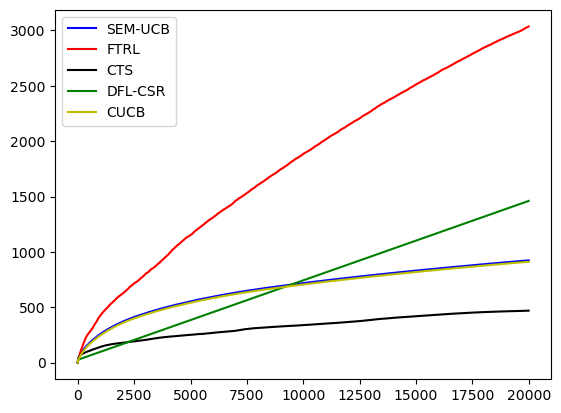

In [39]:
plt.plot(aaaa,c='b',label="SEM-UCB");# SEM-UCB
plt.plot(pseudo_regret,c='r',label="FTRL"); # FTRL
plt.plot(ffff,c='k',label="CTS"); # CTS
plt.plot(eeee,c='g',label="DFL-CSR"); # DFL-CSR
plt.plot(dddd,c='y',label="CUCB"); # CUCB 

plt.legend();
#plt.show()

C:\Users\Behzad_NouraniKoliji\AppData\Local\Temp\ipykernel_8536\2256160892.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "," (-> marker=','). The keyword argument will take precedence.
  plt.plot(range(1,3800),np.transpose(Y1),',',color = 'b', linestyle="dashed",linewidth=1, marker = 'x', mew = '8', ms='2', markevery=70,label='SEM-UCB');
C:\Users\Behzad_NouraniKoliji\AppData\Local\Temp\ipykernel_8536\2256160892.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "," (-> marker=','). The keyword argument will take precedence.
  plt.plot(range(1,3800),np.transpose(Y3),',',color = 'y', linestyle="dashed",linewidth=1, marker = '.', mew = '8', ms='2', markevery=100,label='CUCB');
C:\Users\Behzad_NouraniKoliji\AppData\Local\Temp\ipykernel_8536\2256160892.py:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "," (-> marker=','). The keyword 

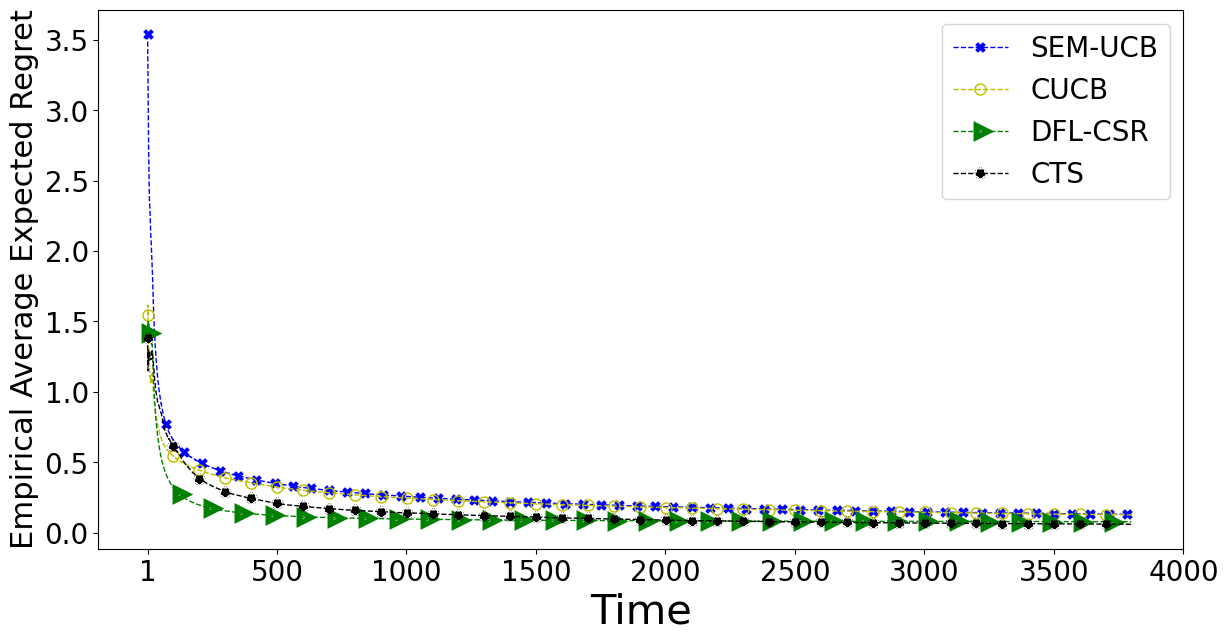

In [40]:
Y1 = aaaa_average[1:3800]
#Y2 = cccc_average[1:3800]
Y3 = dddd_average[1:3800]
Y4 = eeee_average[1:3800]
Y5 = ffff_average[1:3800]

###################### saving the final results in a csv file ################
expected_average_regret_saving=np.zeros((5,Y1.shape[0]))
expected_average_regret_saving[0,:]=Y1
#expected_average_regret_saving[1,:]=Y2
expected_average_regret_saving[2,:]=Y3
expected_average_regret_saving[3,:]=Y4
expected_average_regret_saving[4,:]=Y5
np.savetxt("expected_average_regret_saving.csv", expected_average_regret_saving, delimiter=",")

###############################################################################

#x_range=range(1, 3999)
dim=[1,500,1000,1500,2000,2500,3000,3500,4000]#np.arange(1,4002,500)

#dim=[1,40]
fig = plt.figure(figsize=[14, 7])
#np.arange(1,3999)
plt.plot(range(1,3800),np.transpose(Y1),',',color = 'b', linestyle="dashed",linewidth=1, marker = 'x', mew = '8', ms='2', markevery=70,label='SEM-UCB');
#plt.plot(range(1,3800),np.transpose(Y2),',',color = 'r', linestyle="dashed",linewidth=1, marker = '+', mew = '8', ms='2', markevery=180,label='FTRL');
plt.plot(range(1,3800),np.transpose(Y3),',',color = 'y', linestyle="dashed",linewidth=1, marker = '.', mew = '8', ms='2', markevery=100,label='CUCB');
plt.plot(range(1,3800),np.transpose(Y4),',',color = 'g', linestyle="dashed",linewidth=1, marker = '>', mew = '8', ms='2', markevery=120,label='DFL-CSR');
plt.plot(range(1,3800),np.transpose(Y5),',',color = 'k', linestyle="dashed",linewidth=1, marker = '*', mew = '8', ms='2', markevery=100,label='CTS');

#plt.legend();
#axis_font = {'fontname':'Arial', 'size':'19'}
#plt.xlim(1,3999)
plt.xlabel('Time',fontsize=30)
plt.xticks(dim,fontsize=20)
plt.ylabel("Empirical Average Expected Regret",fontsize=22)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20});
plt.show;
fig.savefig("expected average regrettt.jpg", format = 'jpg', dpi = 300)

# reading from the previously saved data and visualizing again

In [ ]:
from numpy import genfromtxt
my_data = np.asarray([genfromtxt('expected_average_regret_saving.csv', delimiter=',')])

Y1 = my_data[0,0,:]
Y2 = my_data[0,1,:]
Y3 = my_data[0,2,:]
Y4 = my_data[0,3,:]
Y5 = my_data[0,4,:]

In [ ]:

dim=[1,500,1000,1500,2000,2500,3000,3500,4000]#np.arange(1,4002,500)

fig = plt.figure(figsize=[14, 7])
#np.arange(1,3999)
plt.plot(range(1,3999),np.transpose(Y1),',',color = 'b', linestyle="dashed",linewidth=1,  marker = 'x', mew = '8', ms='2', markevery=170,label='SEM-UCB');
plt.plot(range(1,3999),np.transpose(Y2),',',color = 'k', linestyle="solid",linewidth=1,   marker = '+', mew = '8', ms='2', markevery=230,label='FTRL');
plt.plot(range(1,3999),np.transpose(Y3),',',color = 'r', linestyle="dashdot",linewidth=1, marker = '.', mew = '8', ms='2', markevery=150,label='CUCB');
plt.plot(range(1,3999),np.transpose(Y4),',',color = 'g', linestyle="dotted",linewidth=1,  marker = 'X', mew = '8', ms='2', markevery=200,label='DFL-CSR');
plt.plot(range(1,3999),np.transpose(Y5),',',color = 'm', linestyle="dashed",linewidth=1,  marker = '*', mew = '8', ms='2', markevery=150,label='CTS');

#plt.legend();
#axis_font = {'fontname':'Arial', 'size':'19'}
#plt.xlim(1,3999)
plt.xlabel('Time',fontsize=30,labelpad=10)
plt.xticks(dim,fontsize=20)
plt.ylabel("Empirical Average of Expected Regret",fontsize=18,labelpad=5)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 25},ncol=2);
plt.show;
fig.savefig("expected average regrettt.jpg", format = 'jpg', dpi = 300,bbox_inches='tight')

# other visualizations

In [ ]:
plt.plot(np.transpose(aaaa[:3999]),color='r',label='SEM_UCB');
#plt.plot(np.transpose(bbbb),color='b',label='SEM_CTS');
plt.plot(np.transpose(cccc[:3999]),color='g',label='FTRL');
plt.plot(np.transpose(dddd[:3999]),color='y',label='UCB Chen');
plt.plot(np.transpose(eeee[:3999]),color='b',label='UCB Tang');
plt.plot(np.transpose(ffff[:3999]),color='k',label='Pure CTS');
plt.title("Cummulative Expected Regret")
plt.xlim(1,3999)
plt.ylim(0,10000)
plt.legend();
plt.show()
fig.savefig("cummulative expected regret 1.jpg", format = 'jpg', dpi = 300)

In [ ]:
# visualization up to round 1200
fig = plt.figure(figsize=[15, 7])
plt.plot(np.transpose(aaaa_average[:1200]),color='r',label='SEM-UCB');
#plt.plot(np.transpose(bbbb_average),color='b',label='SEM_CTS');
plt.plot(np.transpose(cccc_average[:1200]),color='g',label='FTRL');
plt.plot(np.transpose(dddd_average[:1200]),color='y',label='UCB-Chen');
plt.plot(np.transpose(eeee_average[:1200]),color='b',label='UCB-Tang');
plt.plot(np.transpose(ffff_average[:1200]),color='k',label='CTS');
#plt.title("Expected Average Regret")
plt.xlim(0,1200)
#plt.ylim(0,2500)
plt.xlabel('Round')
plt.ylabel("Average Expected Regret")
plt.legend();
plt.show()
fig.savefig("average expected regret.jpg", format = 'jpg', dpi = 300)